In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
groceries = pd.read_csv('groceries/groceries - groceries.csv', delimiter=',')

with open('recipe-ingredients-dataset/train.json', 'r') as f:
    txt = f.read()
recipes = pd.DataFrame(json.loads(txt))

In [3]:
recipes

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [4]:
#Check ingredients that appear at least 100 times
from collections import Counter

temp_l = recipes["ingredients"]
temp_l = [j for i in temp_l for j in i]
cnt = Counter(temp_l)

ing_value_count = cnt.most_common()
ing_value_count.sort(key= lambda x: x[1], reverse=True)
ing = [(x,y) for x,y in ing_value_count if y>=100]
len(ing)

648

In [5]:
#list of ingredients that appear at least 100 times
ing

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4385),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113),
 ('green onions', 3078),
 ('tomatoes', 3058),
 ('large eggs', 2948),
 ('carrots', 2814),
 ('unsalted butter', 2782),
 ('ground cumin', 2747),
 ('extra-virgin olive oil', 2747),
 ('black pepper', 2627),
 ('milk', 2263),
 ('chili powder', 2036),
 ('oil', 1970),
 ('red bell pepper', 1939),
 ('purple onion', 1896),
 ('scallions', 1891),
 ('grated parmesan cheese', 1886),
 ('sesame oil', 1773),
 ('corn starch', 1757),
 ('ginger', 1755),
 ('baking powder', 1738),
 ('jalapeno chilies', 1730),
 ('dried oregano', 1707),
 ('chopped cilantro fresh', 1698),
 ('fresh lemon juice', 1679),
 ('diced tomatoes', 1624),
 ('fresh parsley', 1604),
 ('minced garlic', 1583),
 ('chicken

In [6]:
#Remove stopwords 
import re

stopwords = 'confectioners cloves ground black all-purpose kosher green large unsalted extra-virgin purple grated dried chopped \
fresh diced minced brown extract dry white yellow boneless skinless breasts breast flat freshly sea dried \
granulated crushed shredded whole halves peeled coarse warm yolks cold flakes whites cooking fat free less sodium \
sliced finely low light cracked spring lean cooked part-skim roasted sliced flank unsweetened sweetened melted fine \
yellow dark smoked toasted crumbles plain evaporated baking firm red 1% low-fat \
reduced-fat italian greek style whole peeled shoulder plain unbleached dry baby and frozen\
button cremini pure reduced steamed nonfat & de medium extra prepared bow-tie pepper salt'

stopwords = stopwords.split(' ')

def remove_stop_words(query):
    querywords = query.split()
    results_word = [word.lower() for word in querywords if word.lower() not in stopwords]
    results = ' '.join(results_word)
    return results


ingredients_filtered = []

for i in recipes["ingredients"]:
    temp_l = []
    for j in i:
        temp_l.append(remove_stop_words(j))
        
    ingredients_filtered.append(temp_l)
    
recipes["ingredients_filtered"] = ingredients_filtered

In [7]:
recipes

,id,cuisine,ingredients,ingredients_filtered
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[romaine lettuce, olives, grape tomatoes, garl..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[flour, , , tomatoes, , thyme, eggs, tomatoes,..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[eggs, , , mayonaise, oil, chilies, grilled ch..."
3,22213,indian,"[water, vegetable oil, wheat, salt]","[water, vegetable oil, wheat, ]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[, shallots, cornflour, cayenne, onions, garli..."
...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...","[sugar, sugar, butter, water, eggs, flour, whe..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...","[kraft zesty dressing, onion, broccoli florets..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...","[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...","[chicken thigh, garlic, rice, powder, corn sta..."


In [8]:
#remove empty strings from ingredients_filtered
def remove_empty_strings(l):
    l = [i for i in l if i]
    return l

recipes["ingredients_filtered"] = recipes["ingredients_filtered"].apply(remove_empty_strings)

In [9]:
# Replacing lemma with token
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

# Ritorna il giusto tag per la parola che analizza (se verbo lo tratta da verbo, se nome da nome, avverbio da avverbio)
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [10]:
# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()
ingredients_filtered_clean = []

for sentence in recipes['ingredients_filtered']:
    ingredients_filtered_clean.append([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence])

recipes["ingredients_filtered_clean"] = ingredients_filtered_clean

In [11]:
recipes

,id,cuisine,ingredients,ingredients_filtered,ingredients_filtered_clean
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[romaine lettuce, olives, grape tomatoes, garl...","[romaine lettuce, olive, grape tomatoes, garli..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[flour, tomatoes, thyme, eggs, tomatoes, corn ...","[flour, tomato, thyme, egg, tomato, corn meal,..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[eggs, mayonaise, oil, chilies, grilled chicke...","[egg, mayonaise, oil, chilies, grilled chicken..."
3,22213,indian,"[water, vegetable oil, wheat, salt]","[water, vegetable oil, wheat]","[water, vegetable oil, wheat]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[shallots, cornflour, cayenne, onions, garlic ...","[shallot, cornflour, cayenne, onion, garlic pa..."
...,...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...","[sugar, sugar, butter, water, eggs, flour, whe...","[sugar, sugar, butter, water, egg, flour, whea..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...","[kraft zesty dressing, onion, broccoli florets...","[kraft zesty dressing, onion, broccoli florets..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...","[eggs, citrus fruit, raisins, sourdough starte...","[egg, citrus fruit, raisin, sourdough starter,..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...","[chicken thigh, garlic, rice, powder, corn sta...","[chicken thigh, garlic, rice, powder, corn sta..."


In [12]:
#Replacing plural form with singluar and fixing some mispelling errors

def plural_to_sigular(string):
    
    res = string.replace('onions', 'onion').replace('olives', 'olive').replace('almonds', 'almond').replace('ribs', 'rib').replace('thighs', 'thigh').replace('potatoes', 'potato').replace('mushrooms', 'mushroom').replace('legs', 'leg').replace('carrots', 'carrot').replace('wings', 'wing').replace('steaks', 'steak').replace('eggs', 'egg').replace('bourbon whiskey', 'whiskey').replace('yoghurt', 'yogurt').replace('jack daniels', 'whiskey')
    print(fatto)
    return res

ingredients_filtered_clean = []

for i in recipes["ingredients_filtered"]:
        temp_l = []
        for j in i:
            temp_l.append(plural_to_sigular(j))
        
        ingredients_filtered_clean.append(temp_l)

recipes["ingredients_filtered_clean"] = ingredients_filtered_clean

In [13]:
recipes

,id,cuisine,ingredients,ingredients_filtered,ingredients_filtered_clean
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[romaine lettuce, olives, grape tomatoes, garl...","[romaine lettuce, olive, grape tomatoes, garli..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[flour, tomatoes, thyme, eggs, tomatoes, corn ...","[flour, tomatoes, thyme, egg, tomatoes, corn m..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[eggs, mayonaise, oil, chilies, grilled chicke...","[egg, mayonaise, oil, chilies, grilled chicken..."
3,22213,indian,"[water, vegetable oil, wheat, salt]","[water, vegetable oil, wheat]","[water, vegetable oil, wheat]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[shallots, cornflour, cayenne, onions, garlic ...","[shallots, cornflour, cayenne, onion, garlic p..."
...,...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...","[sugar, sugar, butter, water, eggs, flour, whe...","[sugar, sugar, butter, water, egg, flour, whea..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...","[kraft zesty dressing, onion, broccoli florets...","[kraft zesty dressing, onion, broccoli florets..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...","[eggs, citrus fruit, raisins, sourdough starte...","[egg, citrus fruit, raisins, sourdough starter..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...","[chicken thigh, garlic, rice, powder, corn sta...","[chicken thigh, garlic, rice, powder, corn sta..."


In [14]:
#Check ingredients count after cleaning procedure
temp_l = recipes["ingredients_filtered_clean"]
temp_l = [j for i in temp_l for j in i]
cnt = Counter(temp_l)

ing_value_count = cnt.most_common()
ing_value_count.sort(key= lambda x: x[1], reverse=True)
top_ing_clean = [(x,y) for x,y in ing_value_count if y>=100]
len(top_ing_clean)

464

In [15]:
#Creating a list of the top ingredients (keeping all ingredients)
top_ing_clean_l = [x[0] for x in top_ing_clean]

#(keeping only the top 400)
#top_ing_clean_l = top_ing_clean_l[0:400]

In [16]:
#Filter out the ingredients keeping only the top ingredients

def filter_ingredients(top_ing, ing):
    ing_filtered = [i for i in ing if i in top_ing]
    return ing_filtered

ingredients_more_filtered = []
for i in recipes["ingredients_filtered_clean"]:
    ingredients_more_filtered.append(filter_ingredients(top_ing_clean_l, i))
    
recipes["ingredients_more_filtered"] = ingredients_more_filtered

In [17]:
recipes

,id,cuisine,ingredients,ingredients_filtered,ingredients_filtered_clean,ingredients_more_filtered
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[romaine lettuce, olives, grape tomatoes, garl...","[romaine lettuce, olive, grape tomatoes, garli...","[romaine lettuce, olive, grape tomatoes, garli..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[flour, tomatoes, thyme, eggs, tomatoes, corn ...","[flour, tomatoes, thyme, egg, tomatoes, corn m...","[flour, tomatoes, thyme, egg, tomatoes, corn m..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[eggs, mayonaise, oil, chilies, grilled chicke...","[egg, mayonaise, oil, chilies, grilled chicken...","[egg, mayonaise, oil, chilies, garlic powder, ..."
3,22213,indian,"[water, vegetable oil, wheat, salt]","[water, vegetable oil, wheat]","[water, vegetable oil, wheat]","[water, vegetable oil]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[shallots, cornflour, cayenne, onions, garlic ...","[shallots, cornflour, cayenne, onion, garlic p...","[shallots, cornflour, cayenne, onion, garlic p..."
...,...,...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...","[sugar, sugar, butter, water, eggs, flour, whe...","[sugar, sugar, butter, water, egg, flour, whea...","[sugar, sugar, butter, water, egg, flour, whea..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...","[kraft zesty dressing, onion, broccoli florets...","[kraft zesty dressing, onion, broccoli florets...","[onion, broccoli florets, pitted olive]"
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...","[eggs, citrus fruit, raisins, sourdough starte...","[egg, citrus fruit, raisins, sourdough starter...","[egg, raisins, flour, sugar, nutmeg, cinnamon,..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...","[chicken thigh, garlic, rice, powder, corn sta...","[chicken thigh, garlic, rice, powder, corn sta...","[chicken thigh, garlic, rice, powder, corn sta..."


In [18]:
#after filtering the ingredients, some recipes are now empty, we remove those empty lists:
boolean_filter = recipes["ingredients_more_filtered"].str.len() == 0
recipes = recipes[boolean_filter == False]

In [19]:
recipes

,id,cuisine,ingredients,ingredients_filtered,ingredients_filtered_clean,ingredients_more_filtered
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[romaine lettuce, olives, grape tomatoes, garl...","[romaine lettuce, olive, grape tomatoes, garli...","[romaine lettuce, olive, grape tomatoes, garli..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[flour, tomatoes, thyme, eggs, tomatoes, corn ...","[flour, tomatoes, thyme, egg, tomatoes, corn m...","[flour, tomatoes, thyme, egg, tomatoes, corn m..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[eggs, mayonaise, oil, chilies, grilled chicke...","[egg, mayonaise, oil, chilies, grilled chicken...","[egg, mayonaise, oil, chilies, garlic powder, ..."
3,22213,indian,"[water, vegetable oil, wheat, salt]","[water, vegetable oil, wheat]","[water, vegetable oil, wheat]","[water, vegetable oil]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[shallots, cornflour, cayenne, onions, garlic ...","[shallots, cornflour, cayenne, onion, garlic p...","[shallots, cornflour, cayenne, onion, garlic p..."
...,...,...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...","[sugar, sugar, butter, water, eggs, flour, whe...","[sugar, sugar, butter, water, egg, flour, whea...","[sugar, sugar, butter, water, egg, flour, whea..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...","[kraft zesty dressing, onion, broccoli florets...","[kraft zesty dressing, onion, broccoli florets...","[onion, broccoli florets, pitted olive]"
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...","[eggs, citrus fruit, raisins, sourdough starte...","[egg, citrus fruit, raisins, sourdough starter...","[egg, raisins, flour, sugar, nutmeg, cinnamon,..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...","[chicken thigh, garlic, rice, powder, corn sta...","[chicken thigh, garlic, rice, powder, corn sta...","[chicken thigh, garlic, rice, powder, corn sta..."


In [20]:
#Create Recipe-Ingredients Matrix
recipes_filtered_df = []

for i in recipes["ingredients_more_filtered"]:
    bin_array = []
    for j in top_ing_clean_l:
        if j in i:
            bin_array.append(1)
        else:
            bin_array.append(0)
    recipes_filtered_df.append(bin_array)
    
recipes_filtered_df = pd.DataFrame(recipes_filtered_df, columns=top_ing_clean_l)

In [21]:
recipes_filtered_df

,onion,garlic,sugar,olive oil,water,egg,butter,flour,tomatoes,ginger,...,chorizo sausage,whipped cream,pecan,leaves,porcini mushroom,pears,lemon grass,masa harina,chicken pieces,mexican oregano
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39684,0,0,1,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
39685,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39686,0,0,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
39687,0,1,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#Apply PCA to this dataset
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca.fit(recipes_filtered_df)

pca_sample = pca.transform(recipes_filtered_df)

In [23]:
#Cluster based on K=10
from sklearn.cluster import KMeans
k = 10
kmeans10 = KMeans(n_clusters=k).fit(recipes_filtered_df)

In [24]:
print("Top terms per cluster:")
order_centroidsK10 = kmeans10.cluster_centers_.argsort()[:, ::-1]
termsK10 = top_ing_clean_l
for i in range(k):
    top_wordsK10 = [termsK10[ind] for ind in order_centroidsK10[i, :30]]
    print("Cluster {}: {}".format(i, ', '.join(top_wordsK10)))

Top terms per cluster:
Cluster 0: egg, flour, milk, butter, onion, water, sugar, vegetable oil, parmesan cheese, garlic, chicken, olive oil, parsley, bread crumbs, mozzarella cheese, oil, powder, garlic powder, nutmeg, heavy cream, buttermilk, lemon juice, shrimp, beef, cheddar cheese, cornmeal, spray, scallions, corn starch, cayenne
Cluster 1: cumin, onion, garlic, cilantro, chili powder, tomatoes, olive oil, chicken, coriander, ginger, cayenne, water, paprika, oregano, beans, lime juice, jalapeno chilies, bell, sour cream, vegetable oil, chicken broth, avocado, cinnamon, yogurt, garam masala, corn tortillas, lime, garlic powder, turmeric, salsa
Cluster 2: onion, olive oil, garlic, tomatoes, bell, wine, oregano, water, parsley, parmesan cheese, basil, carrot, chicken broth, thyme, butter, egg, celery, tomato paste, flour, leaf parsley, chicken, sugar, lemon juice, cilantro, shrimp, bay leaves, zucchini, bay leaf, mushroom, cayenne
Cluster 3: olive oil, onion, water, tomatoes, lemon ju

/home/frabatx/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/home/frabatx/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(*args, **kw)>

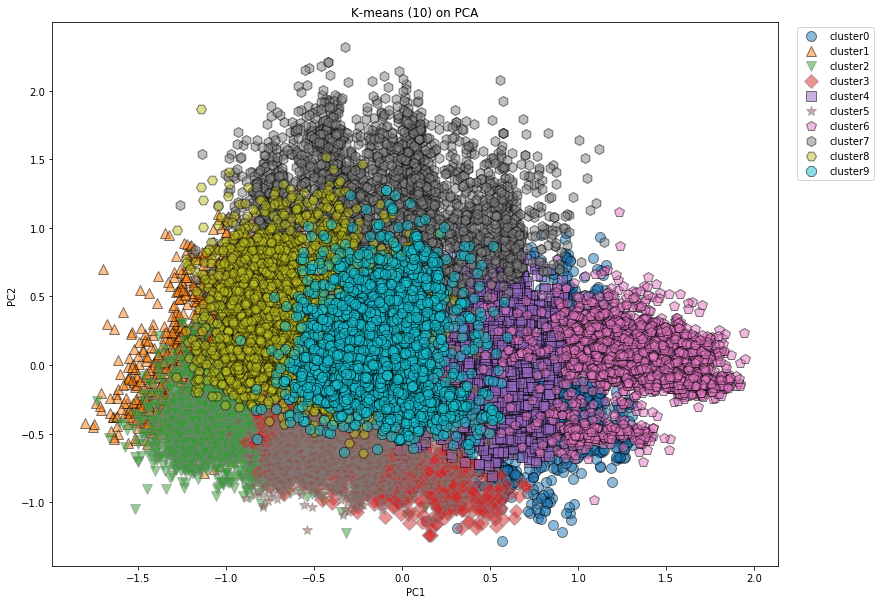

In [25]:
import mglearn

#Plot k-means 10 clusters on PCA
plt.figure(figsize=(13,10))
mglearn.discrete_scatter(pca_sample[:,0], pca_sample[:,1], kmeans10.labels_, alpha = 0.5)
plt.legend(['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4',
       'cluster5', 'cluster6', 'cluster7', 'cluster8', 'cluster9'], bbox_to_anchor=(1.02, 1), loc=2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means (10) on PCA")
plt.show

In [26]:
#Cluster based on K=50
from sklearn.cluster import KMeans
k = 50
kmeans50 = KMeans(n_clusters=k).fit(recipes_filtered_df)

In [27]:
print("Top terms per cluster:")
order_centroidsK50 = kmeans50.cluster_centers_.argsort()[:, ::-1]
termsK50 = top_ing_clean_l
for i in range(k):
    top_wordsK50 = [termsK50[ind] for ind in order_centroidsK50[i, :30]]
    print("/n Cluster {}: {}".format(i, ', '.join(top_wordsK50)))

Top terms per cluster:
/n Cluster 0: basil, garlic, tomatoes, olive oil, onion, oregano, parmesan cheese, sugar, parsley, bell, wine, tomato paste, water, zucchini, mozzarella cheese, tomato sauce, mushroom, balsamic vinegar, thyme, eggplant, chicken, spray, wine vinegar, capers, feta cheese, beef, chicken broth, olive, leaf parsley, spaghetti
/n Cluster 1: sugar, egg, lemon juice, lime juice, mayonaise, milk, oil, tomatoes, lime, yogurt, cinnamon, honey, lemon, ginger, cilantro, ice, orange, coconut milk, mint, wine, sour cream, orange juice, cucumber, condensed milk, hot sauce, rice, parmesan cheese, whipping cream, carrot, cayenne
/n Cluster 2: sesame oil, soy sauce, sugar, sesame seeds, rice vinegar, scallions, garlic, carrot, egg, onion, vegetable oil, water, rice, corn starch, honey, chicken, ginger, pork, cilantro, tofu, beansprouts, oil, shrimp, hoisin sauce, cucumber, vinegar, olive oil, canola oil, shiitake, spinach
/n Cluster 3: sugar, egg, milk, flour, butter, vegetable oil

<function matplotlib.pyplot.show(*args, **kw)>

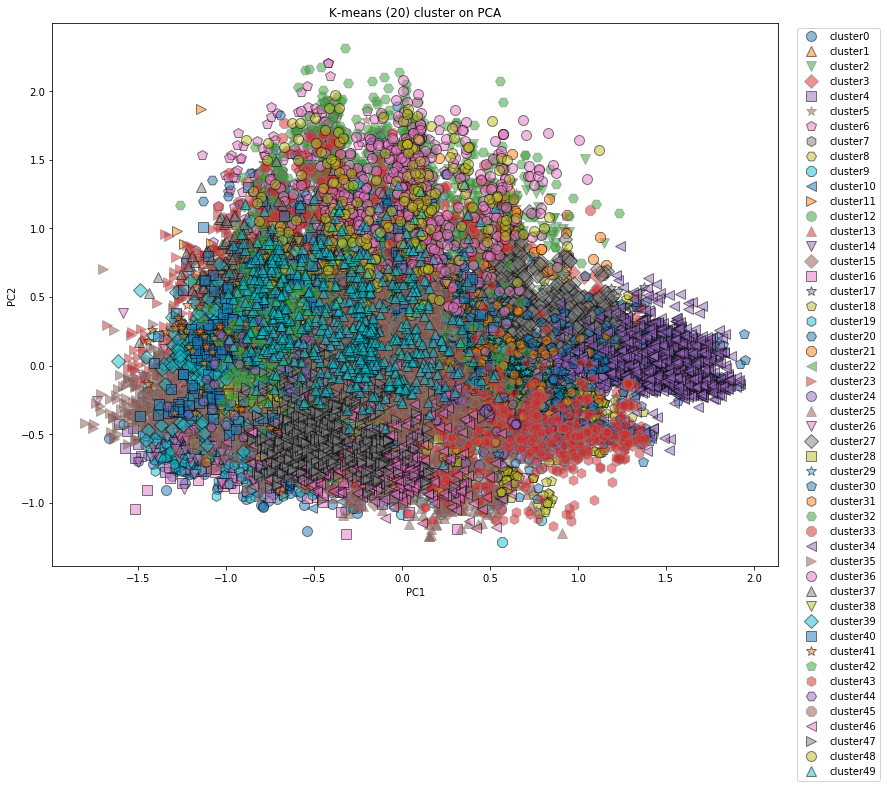

In [28]:
#Plot k-means 50 clusters on PCA
plt.figure(figsize=(13,10))
mglearn.discrete_scatter(pca_sample[:,0], pca_sample[:,1], kmeans50.labels_, alpha = 0.5)
plt.legend(['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4',
       'cluster5', 'cluster6', 'cluster7', 'cluster8', 'cluster9', 'cluster10',
       'cluster11', 'cluster12', 'cluster13', 'cluster14', 'cluster15',
       'cluster16', 'cluster17', 'cluster18', 'cluster19', 'cluster20', 'cluster21', 'cluster22', 'cluster23', 'cluster24',
       'cluster25', 'cluster26', 'cluster27', 'cluster28', 'cluster29', 'cluster30',
       'cluster31', 'cluster32', 'cluster33', 'cluster34', 'cluster35',
       'cluster36', 'cluster37', 'cluster38', 'cluster39', 'cluster40', 'cluster41', 'cluster42', 'cluster43', 'cluster44',
       'cluster45', 'cluster46', 'cluster47', 'cluster48', 'cluster49'], bbox_to_anchor=(1.02, 1), loc=2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means (20) cluster on PCA")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

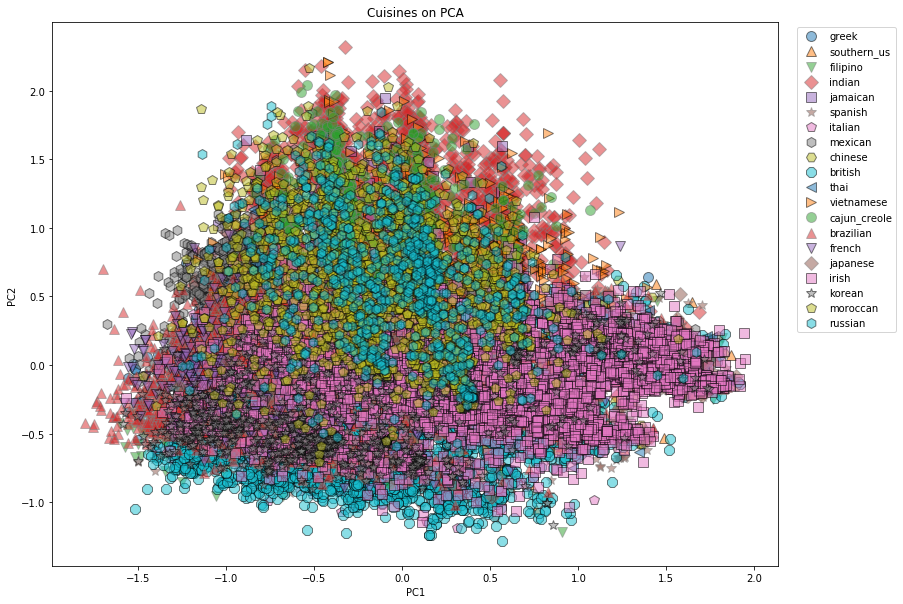

In [29]:
#Plot cuisines on PCA
plt.figure(figsize=(13,10))
mglearn.discrete_scatter(pca_sample[:,0], pca_sample[:,1], recipes.cuisine, alpha = 0.5)
plt.legend(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], bbox_to_anchor=(1.02, 1), loc=2)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Cuisines on PCA")
plt.show

## Data preparation for market basekt dataset

In [30]:
# Convert Market Basket dataset to arrays
groceries_array = groceries.values

# Remove NaN from baskets_arrays
groceries_array_clean = []
for i in groceries_array:
   groceries_array_clean.append([x for x in i if str(x) !='nan'])

df_groceries_clean = pd.DataFrame()
df_groceries_clean["items"] = groceries_array_clean

#remove first element from list (the number of elements)
for index, row in df_groceries_clean.iterrows():
    row['items'].pop(0)

In [31]:
df_groceries_clean.head()

,items
0,"[citrus fruit, semi-finished bread, margarine,..."
1,"[tropical fruit, yogurt, coffee]"
2,[whole milk]
3,"[pip fruit, yogurt, cream cheese, meat spreads]"
4,"[other vegetables, whole milk, condensed milk,..."


In [32]:
#Check unique elements in Market basekt dataset
baskets = list(df_groceries_clean["items"])
unique_ele = set(x for l in baskets for x in l)
len(unique_ele)

169

In [58]:
#impostare lo stesso formato di dataset che abbiamo per le ricette
#Remove stopwords 
import re

stopwords = 'confectioners cloves ground black all-purpose kosher green large unsalted extra-virgin purple grated dried chopped \
fresh diced minced brown extract dry white yellow boneless skinless breasts breast flat freshly sea dried \
granulated crushed shredded whole halves peeled coarse warm yolks cold flakes whites cooking fat free less sodium \
sliced finely low light cracked spring lean citrus cooked part-skim roasted sliced flank unsweetened sweetened melted fine \
yellow dark smoked boiling toasted crumbles plain evaporated baking firm red 1% low-fat cake \
button cremini pure reduced steamed nonfat & de medium specialty white whole spread root other semi-finished bottled \
canned frozen "(appetizer)" packaged instant misc. '

stopwords = stopwords.split(' ')

def remove_stop_words(query):
    querywords = query.split()
    results_word = [word.lower() for word in querywords if word.lower() not in stopwords]
    results = ' '.join(results_word)
    return results


ingredients_filtered = []

for i in df_groceries_clean["items"]:
    temp_l = []
    for j in i:
        temp_l.append(remove_stop_words(j))
        
    ingredients_filtered.append(temp_l)
    
df_groceries_clean["items_filtered"] = ingredients_filtered

In [59]:
#remove empty strings from ingredients_filtered
def remove_empty_strings(l):
    l = [i for i in l if i]
    return l

df_groceries_clean["items_filtered"] = df_groceries_clean["items_filtered"].apply(remove_empty_strings)

In [60]:
df_groceries_clean

,items,items_filtered,items_filtered_clean
0,"[citrus fruit, semi-finished bread, margarine,...","[fruit, bread, margarine, ready soups]","[citrus fruit, bread, margarine, ready soups]"
1,"[tropical fruit, yogurt, coffee]","[tropical fruit, yogurt, coffee]","[tropical fruit, yogurt, coffee]"
2,[whole milk],[milk],[milk]
3,"[pip fruit, yogurt, cream cheese, meat spreads]","[pip fruit, yogurt, cream cheese, meat spreads]","[pip fruit, yogurt, cream cheese, meat spreads]"
4,"[other vegetables, whole milk, condensed milk,...","[vegetables, milk, condensed milk, long life b...","[vegetable, milk, condensed milk, long life ba..."
...,...,...,...
9830,"[sausage, chicken, beef, hamburger meat, citru...","[sausage, chicken, beef, hamburger meat, fruit...","[sausage, chicken, beef, hamburger meat, citru..."
9831,[cooking chocolate],[chocolate],[chocolate]
9832,"[chicken, citrus fruit, other vegetables, butt...","[chicken, fruit, vegetables, butter, yogurt, d...","[chicken, citrus fruit, vegetable, butter, yog..."
9833,"[semi-finished bread, bottled water, soda, bot...","[bread, water, soda, beer]","[bread, water, soda, beer]"


In [61]:
#Check unique elements in Market basekt dataset
baskets = list(df_groceries_clean["items_filtered"])
unique_mb = set(x for l in baskets for x in l)
len(unique_mb)

148

In [62]:
# Replacing lemma with token
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

# Ritorna il giusto tag per la parola che analizza (se verbo lo tratta da verbo, se nome da nome, avverbio da avverbio)
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [63]:
# Replacing lemma with token
lemmatizer = WordNetLemmatizer()
items_filtered_clean = []

for sentence in df_groceries_clean['items_filtered']:
    items_filtered_clean.append([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence])

df_groceries_clean["items_filtered_clean"] = items_filtered_clean

In [64]:
df_groceries_clean

,items,items_filtered,items_filtered_clean
0,"[citrus fruit, semi-finished bread, margarine,...","[fruit, bread, margarine, ready soups]","[fruit, bread, margarine, ready soups]"
1,"[tropical fruit, yogurt, coffee]","[tropical fruit, yogurt, coffee]","[tropical fruit, yogurt, coffee]"
2,[whole milk],[milk],[milk]
3,"[pip fruit, yogurt, cream cheese, meat spreads]","[pip fruit, yogurt, cream cheese, meat spreads]","[pip fruit, yogurt, cream cheese, meat spreads]"
4,"[other vegetables, whole milk, condensed milk,...","[vegetables, milk, condensed milk, long life b...","[vegetable, milk, condensed milk, long life ba..."
...,...,...,...
9830,"[sausage, chicken, beef, hamburger meat, citru...","[sausage, chicken, beef, hamburger meat, fruit...","[sausage, chicken, beef, hamburger meat, fruit..."
9831,[cooking chocolate],[chocolate],[chocolate]
9832,"[chicken, citrus fruit, other vegetables, butt...","[chicken, fruit, vegetables, butter, yogurt, d...","[chicken, fruit, vegetable, butter, yogurt, de..."
9833,"[semi-finished bread, bottled water, soda, bot...","[bread, water, soda, beer]","[bread, water, soda, beer]"


In [41]:
#Check unique elements in recipes dataset
baskets = list(recipes["ingredients_more_filtered"])
unique_recipes = set(x for l in baskets for x in l)
len(unique_recipes)


464

In [42]:
# controllo gli elementi in comune tra i due dataset puliti
common_items =[]
for items in unique_recipes:
    if items in unique_mb:
        common_items.append(items)

len(common_items)

38

## Converto vegetali e frutta in recipes

In [43]:
import WikipediaExtraction as we

fruits = we.getFruits()
vegetables = we.getVegetables()

In [49]:
for recipe in recipes["ingredients_more_filtered"]:
    for index, ingredient in enumerate(recipe):
        if(ingredient in fruits):
            recipe[index] = "fruits"
        if("fruit" in ingredient or "fruits" in ingredient):
            recipe[index] = "fruits"
        if(ingredient in vegetables):
            recipe[index] = "vegetables"
        if("vegetable" in ingredient or "vegetables" in ingredient):
            recipe[index] = "vegetables"

In [50]:
#Check unique elements in recipes dataset
baskets = list(recipes["ingredients_more_filtered"])
unique_recipes = set(x for l in baskets for x in l)
len(unique_recipes)

0        [romaine lettuce, olive, grape tomatoes, veget...
1        [flour, tomatoes, thyme, egg, tomatoes, corn m...
2        [egg, mayonaise, oil, chilies, garlic powder, ...
3                                   [water, vegetable oil]
4        [shallots, cornflour, cayenne, vegetables, gar...
                               ...                        
39769    [sugar, sugar, butter, water, egg, flour, whea...
39770         [vegetables, broccoli florets, pitted olive]
39771    [egg, raisins, flour, sugar, fruits, cinnamon,...
39772    [chicken thigh, vegetables, rice, powder, corn...
39773    [chile, jalapeno chilies, vegetables, cilantro...
Name: ingredients_more_filtered, Length: 39689, dtype: object

Notiamo che abbiamo eliminato 40 elementi unici all'interno del dataset recipes

In [51]:
#Check unique elements in recipes dataset
baskets = list(recipes["ingredients_more_filtered"])
unique_recipes = set(x for l in baskets for x in l)
len(unique_recipes)

422

# Converto vegetali e frutta su groceries

In [65]:
for recipe in df_groceries_clean["items_filtered_clean"]:
    for index, ingredient in enumerate(recipe):
        #print("Ingrediente prima: {0}".format(ingredient))
        if(ingredient in fruits):
            recipe[index] = "fruits"
        if("fruit" in ingredient or "fruits" in ingredient):
            recipe[index] = "fruits"
            #print("Frutta: {0}".format(ingredient))
        if(ingredient in vegetables):
            recipe[index] = "vegetables"
        if("vegetable" in ingredient or "vegetables" in ingredient):
            recipe[index] = "vegetables"
            #print("Vegetale: {0}".format(ingredient))

In [66]:
#Check unique elements in Market basekt dataset
baskets = list(df_groceries_clean["items_filtered_clean"])
unique_mb = set(x for l in baskets for x in l)
len(unique_mb)

141

In [67]:
# controllo gli elementi in comune tra i due dataset puliti
common_items =[]
for items in unique_recipes:
    if items in unique_mb:
        common_items.append(items)

len(common_items)

37

In [68]:
common_items

['cheese',
 'bread',
 'pasta',
 'wine',
 'rice',
 'flour',
 'milk',
 'chicken',
 'chocolate',
 'vegetables',
 'brandy',
 'sauce',
 'ketchup',
 'oil',
 'soda',
 'pork',
 'water',
 'mayonnaise',
 'beef',
 'rum',
 'margarine',
 'meat',
 'powder',
 'butter',
 'honey',
 'sugar',
 'salad dressing',
 'cream',
 'vinegar',
 'turkey',
 'yogurt',
 'ham',
 'fruits',
 'cream cheese',
 'condensed milk',
 'beer',
 'sausage']